# Speech Command Recognition 

This notebook presents an attention model for speech command recognotion. We use Google Speech Commands Dataset to test the Keras generator for sound files and the proposed RNN attention model.


## Download files and load information

Dynamically load speech data from the disk to allow handling big datasets.

First step: download Google Speech Command Dataset and convert all WAV files to numpy arrays for faster load (about 10x faster than loading raw WAV).

In [0]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16348215167929619033
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 9118154617452882498
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 4338675519905709823
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11330115994
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6268264439467106294
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


In [0]:
useColab=True
if useColab:
    !wget -q https://raw.githubusercontent.com/OrionStar25/Attention-Based-Speech-Recognition-Based-on-RNN/master/SpeechDownloader.py?token=AG4AACP5LS77J65QGCCERYC52F3W6
    # !wget -q https://raw.githubusercontent.com/OrionStar25/Attention-Based-Speech-Recognition-Based-on-RNN/master/SpeechGenerator.py
    # !wget -q https://raw.githubusercontent.com/OrionStar25/Attention-Based-Speech-Recognition-Based-on-RNN/master/audioUtils.py
    # !wget -q https://raw.githubusercontent.com/OrionStar25/Attention-Based-Speech-Recognition-Based-on-RNN/master/SpeechModels.py
    # !wget -q https://raw.githubusercontent.com/OrionStar25/Attention-Based-Speech-Recognition-Based-on-RNN/master/requirements.txt
    # !pip install -r requirements.txt

In [6]:
import SpeechDownloader

ModuleNotFoundError: ignored

In [0]:
%load_ext autoreload
%autoreload 2

import librosa
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

import SpeechDownloader
import SpeechGenerator
import SpeechModels

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [0]:
#Download and prepare all data
gscInfo, nCategs = SpeechDownloader.PrepareGoogleSpeechCmd(version=2, task = '35word')

0it [00:00, ?it/s]

Google Speech commands dataset version 2 already exists. Skipping download.
Converting test set WAVs to numpy files
Converting training set WAVs to numpy files



0it [00:00, ?it/s]


Done preparing Google Speech commands dataset version 2


We should have 4 datasets, each with file names 'files' and their categories 'labels' in a dict.

In [0]:
print(gscInfo.keys())
print(gscInfo['train'].keys())
print(len(gscInfo['train']['files']))
print(nCategs)

dict_keys(['train', 'test', 'val', 'testREAL'])
dict_keys(['files', 'labels'])
84849
36


# Speech Data Generator

Use Keras to create a generator that reads files on the fly.

In [0]:
sr=16000 #we know this one for google audios
iLen = 16000
trainGen = SpeechGenerator.SpeechGen(gscInfo['train']['files'], gscInfo['train']['labels'], shuffle=True)
#handle the fact that number of samples in validation may not be multiple of batch_size with shuffle=True
valGen   = SpeechGenerator.SpeechGen(gscInfo['val']['files'], gscInfo['val']['labels'], shuffle=True)

#use batch_size = total number of files to read all test files at once
testGen  = SpeechGenerator.SpeechGen(gscInfo['test']['files'], gscInfo['test']['labels'], shuffle=False, batch_size=len(gscInfo['test']['files']))
testRGen = SpeechGenerator.SpeechGen(gscInfo['testREAL']['files'], gscInfo['testREAL']['labels'], shuffle=False, batch_size=len(gscInfo['testREAL']['files']))
valGen.__len__()

155

In [0]:
audios, classes = valGen.__getitem__(6)
classes

array([29, 31,  7,  1, 12,  4,  6, 11,  4,  7,  9, 16, 19,  4, 16, 32, 16,
       22,  2, 14, 20,  4,  7, 26, 28,  9, 35, 28,  1, 35, 11, 30, 25,  6,
       12, 15, 12, 27, 33, 23, 18,  8, 16, 35, 18,  1,  6, 19,  5, 10, 19,
       18, 30, 15, 13, 20, 21, 12,  5, 14,  8, 16, 33,  8])

In [0]:
audios

array([[ 9.15527344e-05, -3.05175781e-05, -9.15527344e-05, ...,
        -4.27246094e-04, -3.66210938e-04, -3.66210938e-04],
       [-6.10351562e-05, -6.10351562e-05, -6.10351562e-05, ...,
        -2.20336914e-02, -7.00073242e-02, -1.18560791e-01],
       [-3.05175781e-05, -3.05175781e-05, -3.05175781e-05, ...,
        -5.71105957e-01, -5.95642090e-01, -5.99212646e-01],
       ...,
       [-1.67846680e-03, -1.89208984e-03, -2.99072266e-03, ...,
         2.01416016e-03,  1.43432617e-03,  2.22778320e-03],
       [ 3.05175781e-04,  5.18798828e-04,  6.71386719e-04, ...,
        -6.71386719e-04, -9.76562500e-04, -1.03759766e-03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

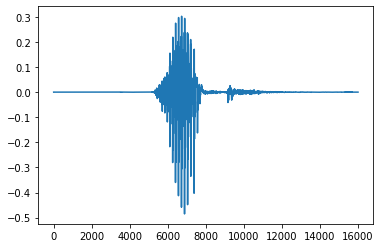

In [0]:
librosa.output.write_wav('file.wav', audios[5], sr, norm=False)
plt.plot(audios[5])

In [0]:
from keras.models import Sequential
from kapre.time_frequency import Melspectrogram, Spectrogram
from kapre.utils import Normalization2D

melspecModel = Sequential()

melspecModel.add(Melspectrogram(n_dft=1024, n_hop=128, input_shape=(1, iLen),
                         padding='same', sr=sr, n_mels=80,
                         fmin=40.0, fmax=sr/2, power_melgram=1.0,
                         return_decibel_melgram=True, trainable_fb=False,
                         trainable_kernel=False,
                         name='mel_stft') )

melspecModel.add(Normalization2D(int_axis=0))

melspecModel.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mel_stft (Melspectrogram)    (None, 80, 125, 1)        1091664   
_________________________________________________________________
normalization2d_3 (Normaliza (None, 80, 125, 1)        0         
Total params: 1,091,664
Trainable params: 0
Non-trainable params: 1,091,664
_________________________________________________________________


In [0]:
melspec = melspecModel.predict( audios.reshape((-1,1,iLen)) )
melspec.shape

(64, 80, 125, 1)

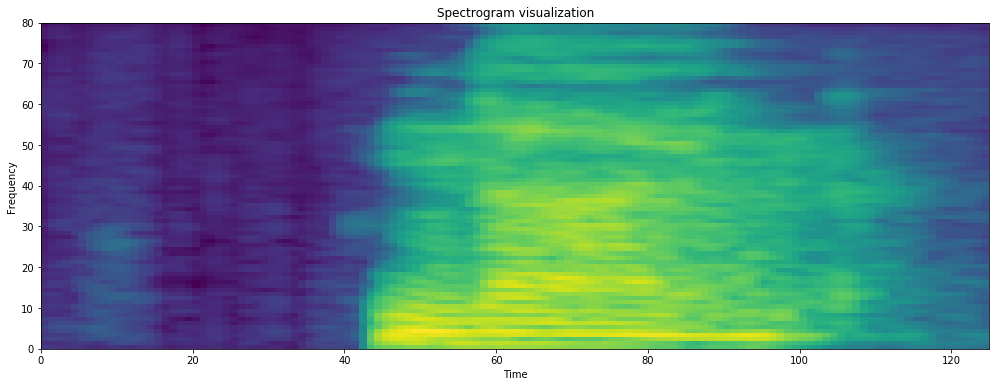

In [0]:
plt.figure(figsize=(17,6))
plt.pcolormesh(melspec[45,:,:,0])

plt.title('Spectrogram visualization')
plt.ylabel('Frequency')
plt.xlabel('Time')

plt.show()

(array([8.00000e+01, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        1.00000e+00, 1.00000e+00, 1.00000e+00, 4.00000e+00, 7.00000e+00,
        2.00000e+00, 8.00000e+00, 7.00000e+00, 5.00000e+00, 3.10000e+01,
        4.90000e+01, 1.09400e+03, 9.00000e+01, 7.70000e+01, 1.43000e+02,
        8.30000e+01, 6.50000e+01, 1.41000e+02, 2.19000e+02, 2.89000e+02,
        3.52000e+02, 4.18000e+02, 6.01000e+02, 9.84000e+02, 1.74600e+03,
        2.87600e+03, 5.05900e+03, 7.62800e+03, 9.50000e+03, 1.09530e+04,
        1.24960e+04, 1.37060e+04, 1.38990e+04, 1.37250e+04, 1.33340e+04,
        1.29730e+04, 1.26010e+04, 1.21280e+04, 1.14410e+04, 1.12980e+04,
        3.31474e+05, 1.09160e+04, 9.84200e+03, 8.80500e+03, 8.34000e+03,
        7.89000e+03, 7.69900e+03, 7.29200e+03, 6.93400e+03, 6.69600e+03,
        6.24000e+03, 5.88900e+03, 5.52300e+03, 5.13500e+03, 4.45000e+03,
        4.16200e+03, 3.93300e+03, 3.81700e+03, 3.47

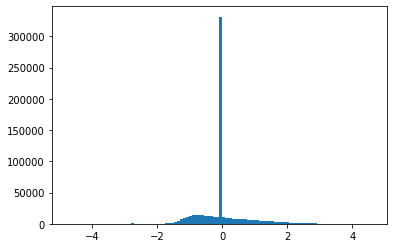

In [0]:
plt.hist(melspec.flatten(), bins=100)

# Models

Create Keras models to see if the generators are working properly

In [0]:
from keras.models import Model, load_model

from keras.layers import Input, Activation, Concatenate, Permute, Reshape, Flatten, Lambda, Dot, Softmax
from keras.layers import Add, Dropout, BatchNormalization, Conv2D, Reshape, MaxPooling2D, Dense, CuDNNLSTM, Bidirectional
from keras import backend as K
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from keras import optimizers

from kapre.time_frequency import Melspectrogram, Spectrogram

In [0]:
# self-attention LSTM
nCategs=36
sr=16000
iLen=16000
from keras import layers as L

model = SpeechModels.AttRNNSpeechModel(nCategs, samplingrate = sr, inputLength = None)#, rnn_func=L.LSTM)

model.compile(optimizer='adam', loss=['sparse_categorical_crossentropy'], metrics=['sparse_categorical_accuracy'])
model.summary()


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None)         0                                            
__________________________________________________________________________________________________
reshape_3 (Reshape)             (None, 1, None)      0           input[0][0]                      
__________________________________________________________________________________________________
mel_stft (Melspectrogram)       (None, 80, None, 1)  1091664     reshape_3[0][0]                  
__________________________________________________________________________________________________
normalization2d_5 (Normalizatio (None, 80, None, 1)  0           mel_stft[0][0]                   
___________________________________________________________________________________________

In [0]:
# model.load_weights('model-attRNN.h5')

In [0]:
# save model to pb ====================
def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    """
    Freezes the state of a session into a pruned computation graph.
    Creates a new computation graph where variable nodes are replaced by
    constants taking their current value in the session. The new graph will be
    pruned so subgraphs that are not necessary to compute the requested
    outputs are removed.
    @param session The TensorFlow session to be frozen.
    @param keep_var_names A list of variable names that should not be frozen,
                          or None to freeze all the variables in the graph.
    @param output_names Names of the relevant graph outputs.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.
    """
    from tensorflow.python.framework.graph_util import convert_variables_to_constants
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = convert_variables_to_constants(session, input_graph_def,
                                                      output_names, freeze_var_names)
        return frozen_graph



In [0]:
wkdir = ''
pb_filename = 'attRNN.pb'

# save keras model as tf pb files ===============
from keras import backend as K
frozen_graph = freeze_session(K.get_session(),
                              output_names=[out.op.name for out in model.outputs])
tf.train.write_graph(frozen_graph, wkdir, pb_filename, as_text=False)

INFO:tensorflow:Froze 140 variables.
INFO:tensorflow:Converted 140 variables to const ops.


'attRNN.pb'

In [0]:
import math
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.4
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop,  
            math.floor((1+epoch)/epochs_drop))
    
    if (lrate < 4e-5):
        lrate = 4e-5
      
    print('Changing learning rate to {}'.format(lrate))
    return lrate
lrate = LearningRateScheduler(step_decay)

In [0]:
# !pip install keras-tqdm

from keras_tqdm import TQDMNotebookCallback
import os 
checkpoint_path = "training_1\model-attRNN.h5" 
# checkpoint_dir = os.path.dirname(checkpoint_path)

earlystopper = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=10, verbose=1)
checkpointer = ModelCheckpoint(checkpoint_path, monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True)
results = model.fit_generator(trainGen, validation_data = valGen, epochs = 5, use_multiprocessing=True, workers=4, verbose=0,
                    callbacks=[earlystopper,checkpointer,lrate, TQDMNotebookCallback()])

Changing learning rate to 0.001


Changing learning rate to 0.001

Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.94123, saving model to training_1\model-attRNN.h5
Changing learning rate to 0.001



Epoch 00002: val_sparse_categorical_accuracy did not improve from 0.94123
Changing learning rate to 0.001



Epoch 00003: val_sparse_categorical_accuracy did not improve from 0.94123
Changing learning rate to 0.001



Epoch 00004: val_sparse_categorical_accuracy did not improve from 0.94123
Changing learning rate to 0.001



Epoch 00005: val_sparse_categorical_accuracy did not improve from 0.94123


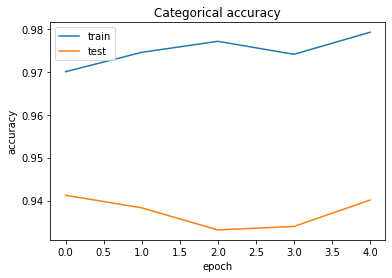

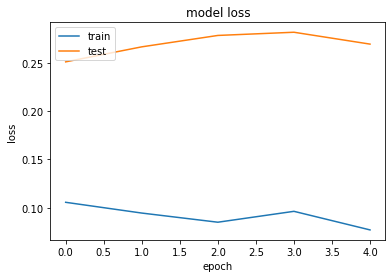

In [0]:
# summarize history for categorical accuracy
plt.plot(results.history['sparse_categorical_accuracy'])
plt.plot(results.history['val_sparse_categorical_accuracy'])
plt.title('Categorical accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
results.history

{'loss': [0.10561833535690071,
  0.0944846162491232,
  0.08500893736075839,
  0.09627360442626941,
  0.0770400378352936],
 'lr': [0.001, 0.001, 0.001, 0.001, 0.001],
 'sparse_categorical_accuracy': [0.9700235849056604,
  0.9745283018867924,
  0.9770990566037736,
  0.9740683962264151,
  0.9792099056603774],
 'val_loss': [0.2509523931169702,
  0.26649083302867027,
  0.2782851703344814,
  0.28159788006976727,
  0.26931299232246897],
 'val_sparse_categorical_accuracy': [0.9412298387096775,
  0.9383064516129033,
  0.9331653225806451,
  0.9339717741935484,
  0.9401209677419354]}

In [0]:
#load best model according to cross-validation - model-attRNN
model = load_model(checkpoint_path, custom_objects={'Melspectrogram': Melspectrogram, 'Normalization2D': Normalization2D })

In [0]:
#read all test data
x_test, y_test = testGen.__getitem__(0)

In [0]:
valEval = model.evaluate_generator(valGen, use_multiprocessing=True, workers=4,verbose=1)
trainEval = model.evaluate_generator(trainGen, use_multiprocessing=True, workers=4,verbose=1)
testEval = model.evaluate(x_test, y_test, verbose=1)
print('Evaluation scores: \nMetrics: {} \nTrain: {} \nValidation: {} \nTest: {}'.format(model.metrics_names, trainEval, valEval, testEval) )

11005/11005 [==============================] - 22s 2ms/step
Evaluation scores: 
Metrics: ['loss', 'sparse_categorical_accuracy'] 
Train: [0.07619462692802596, 0.9800589622641509] 
Validation: [0.25712954190469556, 0.9402217741935484] 
Test: [0.2549938964995994, 0.9355747387659435]


In [0]:
#only for the Kaggle competition, 12-cmd
x_testR, y_testR = testRGen.__getitem__(0)
testREval = model.evaluate(x_testR, y_testR, verbose=1)
testREval

4890/4890 [==============================] - 10s 2ms/step


[1.8371147400153427, 0.7838445808014743]

In [0]:
testREval = model.evaluate_generator(testRGen, use_multiprocessing=True, workers=4,verbose=1)
testREval

1/1 [==============================] - 13s 13s/step


[1.8333097696304321, 0.7856850624084473]

In [0]:
# Evaluation and Attention Plots

In [0]:
attSpeechModel = Model(inputs=model.input,
                                 outputs=[model.get_layer('output').output, 
                                          model.get_layer('attSoftmax').output,
                                          model.get_layer('mel_stft').output])


In [0]:
audios, classes = valGen.__getitem__(3)
classes

array([12, 21,  3, 17,  7,  3, 26,  9,  5,  4, 20,  5, 12, 29, 16, 17,  1,
       14,  3,  5,  2, 10,  8, 11, 22,  9, 20, 16, 19,  9, 15,  7, 15, 25,
       16,  8, 35,  2, 17, 13,  1, 28,  2, 20, 26, 20, 24, 24,  8, 18,  2,
        1, 25, 17, 17, 19, 20,  8, 12, 15,  7, 28,  1, 17])

In [0]:
#8 - on, 13 - one, 7 - right
idAudio = 8
classes[idAudio]

5

In [0]:
outs, attW, specs = attSpeechModel.predict( audios )

In [0]:
np.argmax(outs,axis=1)

array([12, 21,  3, 17,  7, 16, 26, 16,  5,  4, 20,  5, 12, 29, 16, 17,  1,
       25,  3,  5,  2, 10,  8, 11, 22,  9, 20, 16, 19,  9, 15,  7, 15, 25,
       16,  8, 35,  2, 17, 13,  1, 28,  2, 20, 26, 18, 24, 24,  8, 18,  2,
        1, 25, 17, 17, 19, 20,  8, 12, 15,  7, 28,  1, 27])

In [0]:
specs.shape

(64, 80, 125, 1)

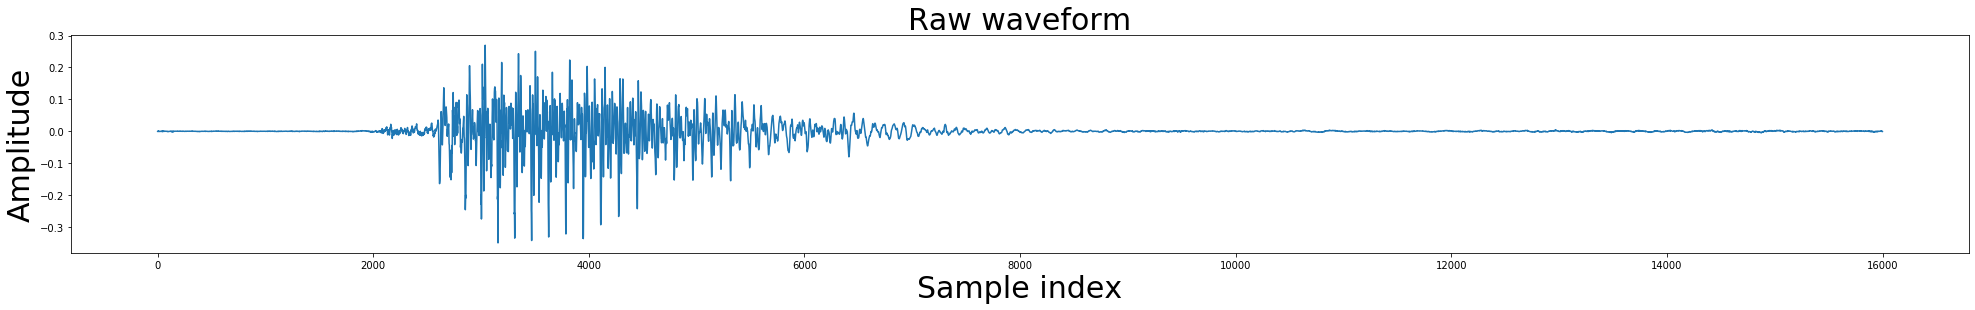

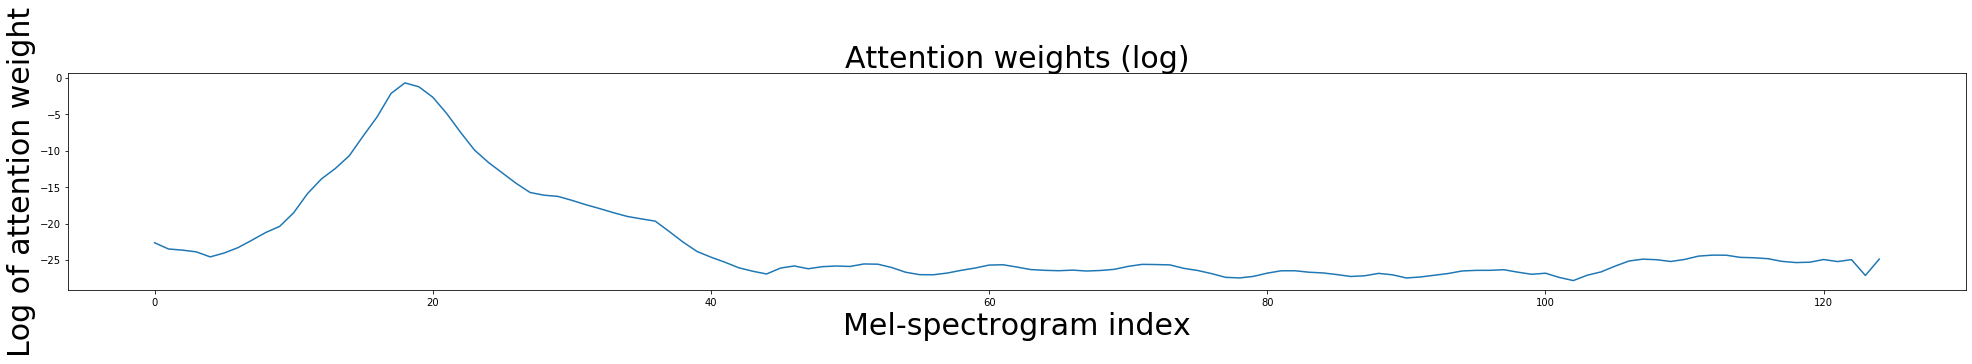

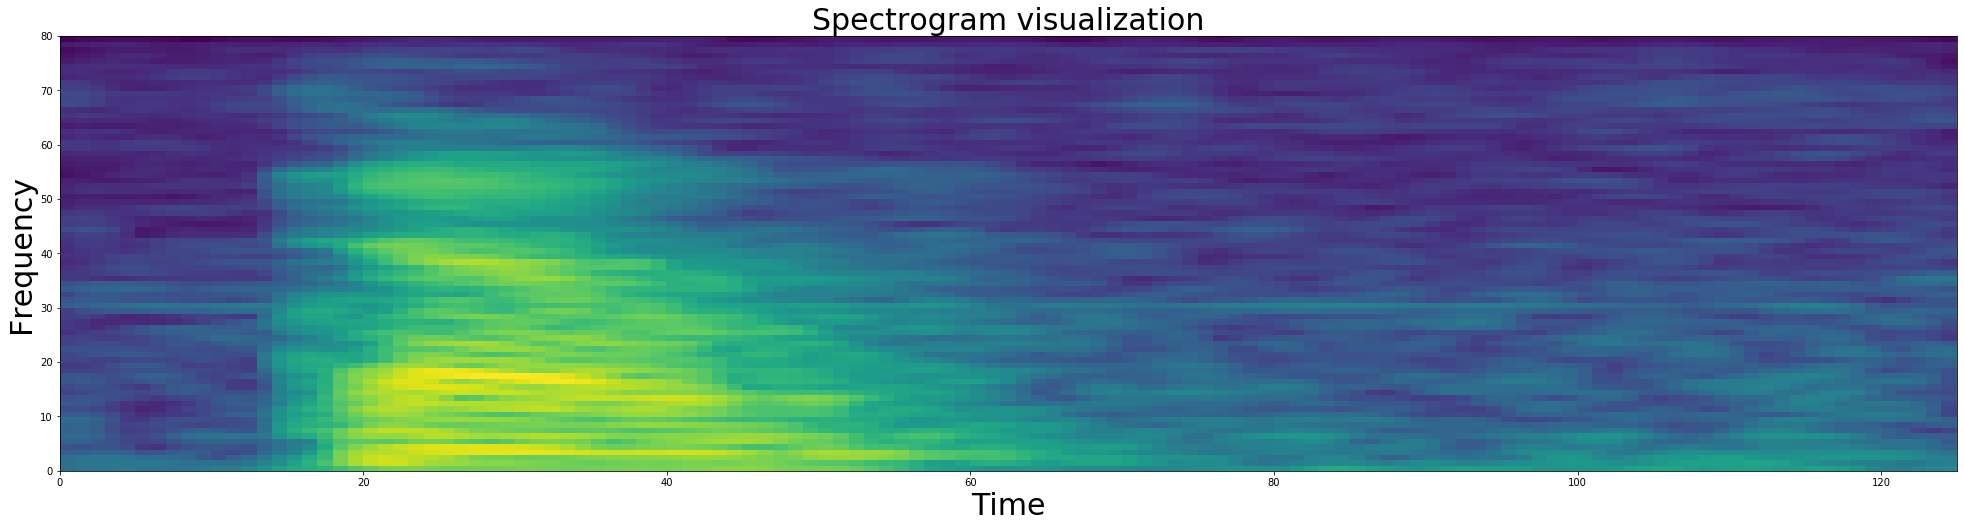

In [0]:

imgHeight = 2*2

plt.figure(figsize=(17*2,imgHeight))
plt.title('Raw waveform', fontsize=30)
plt.ylabel('Amplitude', fontsize=30)
plt.xlabel('Sample index', fontsize=30)
plt.plot(audios[idAudio])
plt.savefig('picrawWave.png', dpi = 400)
plt.show()

plt.figure(figsize=(17*2,imgHeight))
plt.title('Attention weights (log)', fontsize=30)
plt.ylabel('Log of attention weight', fontsize=30)
plt.xlabel('Mel-spectrogram index', fontsize=30)
plt.plot(np.log(attW[idAudio]))
plt.savefig('picAttention.png', dpi = 400)
plt.show()


plt.figure(figsize=(17*2,imgHeight*2))
plt.pcolormesh(specs[idAudio,:,:,0])

plt.title('Spectrogram visualization', fontsize=30)
plt.ylabel('Frequency', fontsize=30)
plt.xlabel('Time', fontsize=30)
plt.savefig('picmelSpec.png', dpi = 400)

plt.show()

In [0]:
y_pred = model.predict(x_test, verbose=1)

11005/11005 [==============================] - 24s 2ms/step


In [0]:
from sklearn.metrics import confusion_matrix
import audioUtils
cm = confusion_matrix(y_test, np.argmax(y_pred,1))

In [0]:
set(y_test)

{1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35}

In [0]:
#35word, v2
classes = ['nine', 'yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go',
           'zero', 'one', 'two', 'three', 'four', 'five', 'six', 
           'seven',  'eight', 'backward', 'bed', 'bird', 'cat', 'dog',
           'follow', 'forward', 'happy', 'house', 'learn', 'marvin', 'sheila', 'tree',
           'visual', 'wow']

In [0]:
#35word, v1
classes=['nine', 'yes',  'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go',
         'zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven',  'eight', 
         'bed', 'bird', 'cat', 'dog', 'happy', 'house', 
         'marvin', 'sheila', 'tree', 'wow']

In [0]:
#20cmd
classes=['unknown', 'nine', 'yes',  'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go',
         'zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven',  'eight']

Normalized confusion matrix


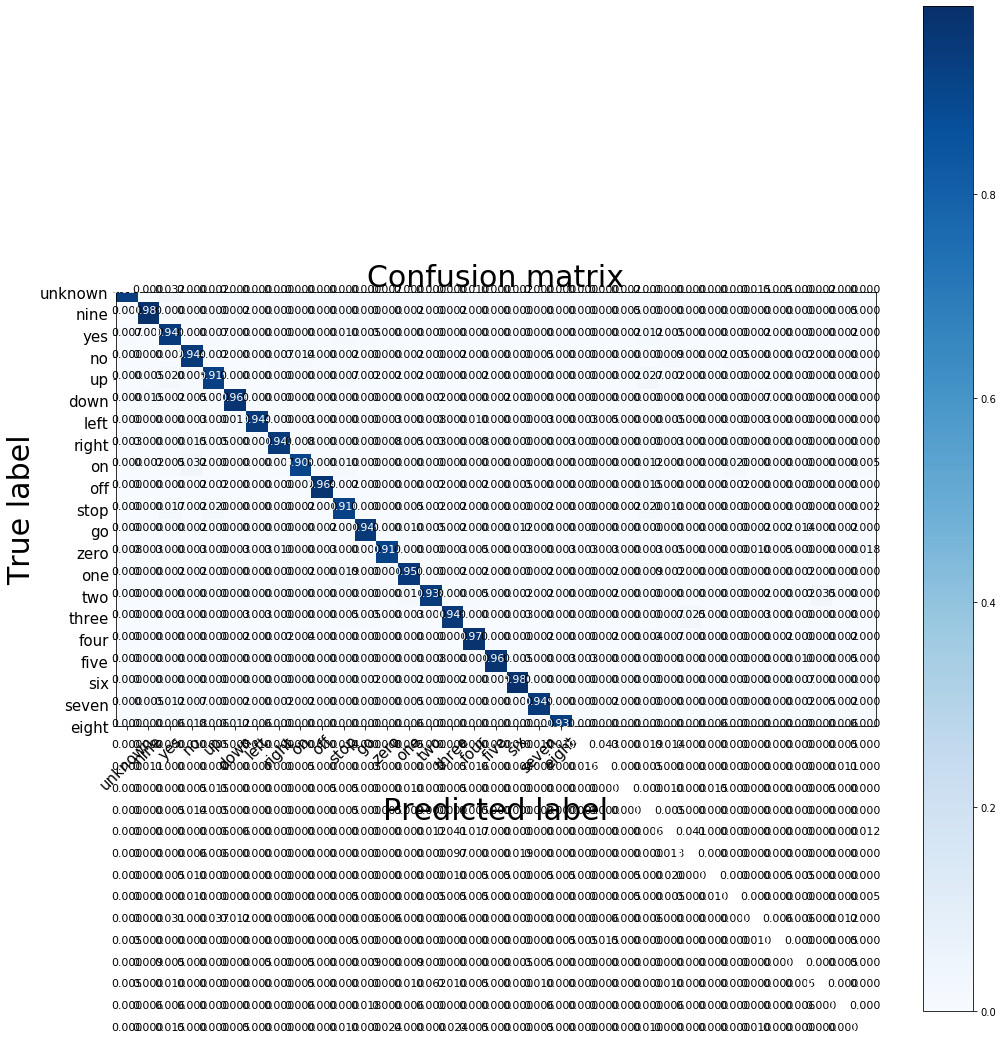

In [0]:
audioUtils.plot_confusion_matrix(cm,classes, normalize=True)